In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import random as rn 
import warnings
warnings.filterwarnings("ignore")

In [2]:

# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [3]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [4]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [5]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [6]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [7]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [8]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [9]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [10]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [11]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [12]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [13]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [14]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [15]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [16]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [17]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [18]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [19]:
common_cells_across_methods = pd.read_csv("../../../../results/Fig7-Granja_BMMC_scATAC/compare_annotation_performances/commonCells.csv", index_col=False)
common_cells_across_methods

,0
0,ACCCAAATCCACTAGA-1
1,ACCTGCTCAATAGCGG-1
2,TACGGATGTTTGCCAA-1
3,ACTTCCGGTGCATCAT-1
4,CTCTCGACAGCTATAC-1
...,...
10747,CCTGCTATCGCATAAC-1
10748,TTGCAGAGTGACGCAA-1
10749,CATAACGGTCACATTG-1
10750,GAGATTCTCCAGGTAT-1


### silver ground truth annotations - from original publication


In [20]:
ground_truth_annotations = pd.read_csv("../../../../data/Granja2019/BMMC_D6T1/03_cellIDs_and_annotations/metadata.csv")

In [21]:
ground_truth_annotations.shape

(12394, 10)

In [22]:
ground_truth_annotations = ground_truth_annotations[["BioClassification", "Barcode"]]
ground_truth_annotations[['cluster_id', 'annotation']] = ground_truth_annotations['BioClassification'].str.split('_', n=1, expand=True)
ground_truth_annotations.index=ground_truth_annotations['Barcode']
ground_truth_annotations.index.name = None
ground_truth_annotations.columns = ["BioClassification","cell_IDs","cluster_id","annotation"]

In [23]:
set(ground_truth_annotations.annotation)

{'B',
 'CD14.Mono.1',
 'CD14.Mono.2',
 'CD4.M',
 'CD4.N1',
 'CD4.N2',
 'CD8.CM',
 'CD8.EM',
 'CD8.N',
 'CLP.1',
 'CLP.2',
 'CMP.LMPP',
 'Early.Baso',
 'Early.Eryth',
 'GMP',
 'GMP.Neut',
 'HSC',
 'Late.Eryth',
 'NK',
 'Plasma',
 'Pre.B',
 'Unk',
 'cDC',
 'pDC'}

In [24]:
ground_truth_renaming_dict={'B':'Bcell',
 'CD14.Mono.1':'Mono',
 'CD14.Mono.2':'Mono',
 'CD4.M':'CD4Tcell',
 'CD4.N1':'CD4Tcell',
 'CD4.N2':'CD4Tcell',
 'CD8.CM':'CD8Tcell',
 'CD8.EM':'CD8Tcell',
 'CD8.N':'CD8Tcell',
 'Early.Baso':'Basofil',
 'GMP':'GMP',
 'HSC':'HSC/MPP',
 'NK':'NKcell',
 'Plasma':'Plasmacell',
 'Unk':'Unknown',
 'cDC':'cDC',
 'pDC':'pDC',
 'CLP.1': 'CLP',
 'CLP.2': 'CLP',
 'CMP.LMPP': 'CMP/LMPP',
 'Early.Eryth': 'Ery',
 'GMP.Neut': 'GMP',
 'Late.Eryth': 'Ery',
 'Pre.B': 'CLP'}

In [25]:
ground_truth_annotations= ground_truth_annotations.assign(ground_truth_annotations_simplified=list(ground_truth_annotations['annotation'].map(ground_truth_renaming_dict)))
ground_truth_annotations.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
CACCTGTTCTTTATCG-1,11_CD14.Mono.1,CACCTGTTCTTTATCG-1,11,CD14.Mono.1,Mono
GCCCAGAAGTGTCACT-1,16_Pre.B,GCCCAGAAGTGTCACT-1,16,Pre.B,CLP
CCTTAATCAGTATACC-1,11_CD14.Mono.1,CCTTAATCAGTATACC-1,11,CD14.Mono.1,Mono
GTGCCAGTCAAGGCAG-1,13_Unk,GTGCCAGTCAAGGCAG-1,13,Unk,Unknown
TGTGTCCAGAAAGCAG-1,11_CD14.Mono.1,TGTGTCCAGAAAGCAG-1,11,CD14.Mono.1,Mono


In [26]:
set(ground_truth_annotations.ground_truth_annotations_simplified)

{'Basofil',
 'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP/LMPP',
 'Ery',
 'GMP',
 'HSC/MPP',
 'Mono',
 'NKcell',
 'Plasmacell',
 'Unknown',
 'cDC',
 'pDC'}

In [27]:
ground_truth_annotations.ground_truth_annotations_simplified.value_counts()

ground_truth_annotations_simplified
CD4Tcell      2846
Mono          2789
GMP           1503
CLP           1244
CD8Tcell      1052
Unknown        616
Bcell          567
Ery            376
pDC            346
NKcell         313
CMP/LMPP       293
Basofil        190
HSC/MPP        125
cDC            111
Plasmacell      23
Name: count, dtype: int64

In [28]:
ground_truth_annotations.shape

(12394, 5)

In [29]:
ground_truth_annotations_known = ground_truth_annotations[ground_truth_annotations['ground_truth_annotations_simplified']!= "Unknown"]

In [30]:
ground_truth_annotations_known.shape

(11778, 5)

In [31]:
leiden_resolutions = ['0.1' ,'0.2' ,'0.3' ,'0.4' ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'1.0' ,'1.1' ,'1.2' ,'1.3' ,'1.4' ,'1.5' ,'1.6' ,'1.7','1.8' ,'1.9' ,'2.0', '2.1', '2.2', '2.3', '2.4', '2.5']

In [32]:
# prepare results dataframe

scores_df = pd.DataFrame( index=['leiden_'+i for i in leiden_resolutions])

In [33]:
for res in leiden_resolutions:
    result_path = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/Granja_BMMC_scATAC_performance_acros_clustering_res/res"+ res + "/outputs/scATAcat_annotations_leiden_" + res +".csv"
    scATAcat_annotations = pd.read_csv(result_path, index_col=0)
    scATAcat_annotations.index.name = None
    scATAcat_annotations.columns = ['leiden_'+ res, 'scATAcat_annotation']
    #scATAcat_annotations.columns = ['leiden_'+res, 'scATAcat_annotation' ,'ground_truth_annotations']
    scATAcat_annotations['cell_IDs'] = scATAcat_annotations.index
    
    cluster_id_column ='leiden_'+res
    scATAcat_annotations.index.name = None
    common_cells = list(common_cells_across_methods['0'])
    all_methods_for_commonCells= get_combined_annotations_df_for_common_cells(scATAcat_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
    common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
    print(common_annotations)
    all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
    annotation_df = all_methods_for_commonCells_commonAnnotations
    correct_id_col = 'ground_truth_annotations_simplified'
    predicted_id_col = "scATAcat_annotation"
    scores_df.loc['leiden_'+ res, "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
    scores_df.loc['leiden_'+ res, "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, 'num_clust'] = scATAcat_annotations['leiden_'+ res].max()+1


['Bcell', 'NKcell', 'CLP', 'Mono', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'Mono', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'pDC', 'CD4Tcell']
['Bcell', 'NKcell', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tcell', 'pDC', 'CD4Tcell', 'GMP']
['Bcell', 'NKcell', 'CLP', 'Mono', 'CD8Tce

In [34]:
['NKcell', 'CD4Tcell', 'pDC', 'CD8Tcell', 'Bcell', 'GMP', 'Mono']

['NKcell', 'CD4Tcell', 'pDC', 'CD8Tcell', 'Bcell', 'GMP', 'Mono']

In [35]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,num_clust
leiden_0.1,0.898398,0.874946,1.000000,0.883070,0.968167,0.976630,0.987270,0.872938,0.817116,0.863311,7.0
leiden_0.2,0.935090,0.918473,1.000000,0.933302,0.969517,0.984728,0.997380,0.913753,0.867778,0.909129,10.0
leiden_0.3,0.881436,0.861964,0.700000,0.813222,0.989351,0.993372,0.993979,0.852927,0.930535,0.838105,13.0
leiden_0.4,0.807866,0.782477,0.833333,0.777753,0.904422,0.981013,0.989796,0.762397,0.691478,0.739795,16.0
leiden_0.5,0.765643,0.738216,0.769231,0.711575,0.733438,0.945093,0.986961,0.720640,0.701753,0.703540,17.0
leiden_0.6,0.738827,0.710250,0.769231,0.667621,0.715541,0.900310,0.986961,0.689392,0.682342,0.667894,17.0
leiden_0.7,0.778383,0.751500,0.785714,0.728316,0.742078,0.954553,0.986961,0.735763,0.714949,0.720340,18.0
leiden_0.8,0.763793,0.736320,0.785714,0.709066,0.732380,0.942478,0.986961,0.718462,0.700144,0.701087,18.0
leiden_0.9,0.763588,0.736105,0.785714,0.708601,0.732240,0.942224,0.986961,0.718212,0.699916,0.700816,19.0
leiden_1.0,0.762458,0.729177,0.733333,0.705896,0.731404,0.949214,0.955329,0.716679,0.696632,0.699222,20.0


In [36]:
scores_df.to_csv('../../../../results/Supplementary_tables/analysis_on_clustering_parameter/Granja_BMMC_scATAC_performance_acros_clustering_res/Granja_BMMC_scATAC_performance_acros_clustering_res.csv')

In [37]:
figures_dir = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/Granja_BMMC_scATAC_performance_acros_clustering_res/figures/"

In [38]:
import os
os.makedirs(figures_dir,exist_ok=True)

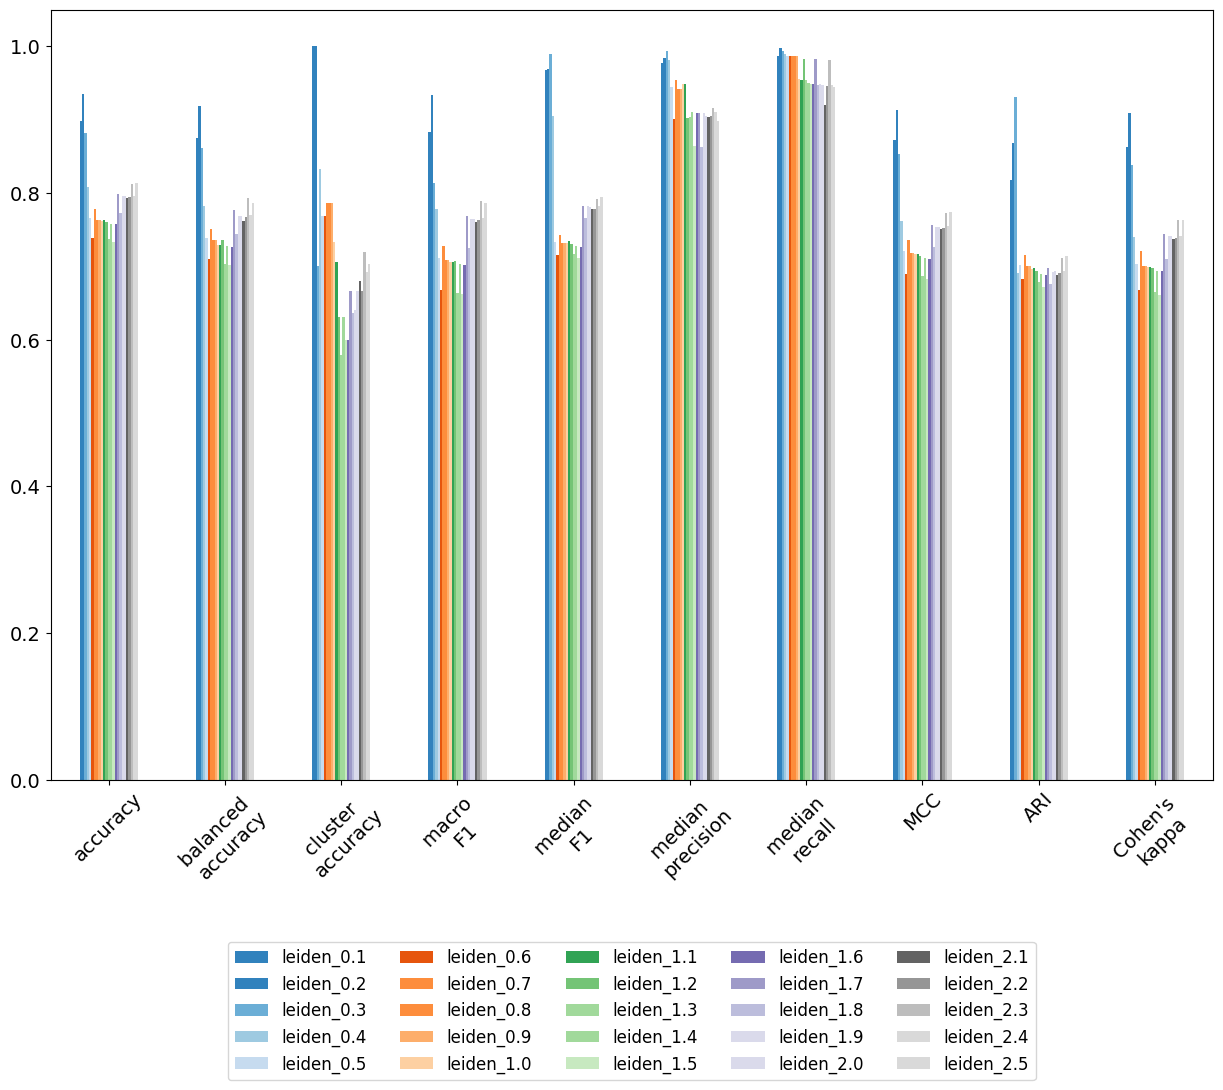

In [39]:
import matplotlib.pyplot as plt
scores_df = scores_df.iloc[:,:-1]
scores_df.columns = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12,colormap='tab20c')
#ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=12)
#plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.show()
plt.savefig(figures_dir + "Granja_BMMC_performance_acros_clustering_res.png", bbox_inches='tight', transparent=True)
